In [4]:
import numpy as np
import matplotlib.pyplot as plt
import re

In [7]:
class PulseSequence:
    def __init__(self, sequence, clock = 300e6):
        self.time_units = {'ns':1, 'us':1e3, 'ms':1e6, 's':1e9}
        self.clock = clock
        
        OFF = int('0b0000 0000 0000 0000 0000 0000'.replace(' ', ''),2)
        ONE_PERIOD = int('0b1000 0000 0000 0000 0000 0000'.replace(' ', ''),2)
        TWO_PERIOD = int('0b0100 0000 0000 0000 0000 0000'.replace(' ', ''),2)
        THREE_PERIOD = int('0b1100 0000 0000 0000 0000 0000'.replace(' ', ''),2)
        FOUR_PERIOD = int('0b0010 0000 0000 0000 0000 0000'.replace(' ', ''),2)
        FIVE_PERIOD = int('0b1010 0000 0000 0000 0000 0000'.replace(' ', ''),2)
        ON = int('0b1110 0000 0000 0000 0000 0000'.replace(' ', ''),2)
        self.fast = [ONE_PERIOD, TWO_PERIOD, THREE_PERIOD, FOUR_PERIOD, FIVE_PERIOD]
            
        if isinstance(sequence, str):
            self.addresses, self.sequence = self._string_to_sequence_list(sequence)
            
    def _string_to_sequence_list(self, instructions_string):
        sequence = [seq.replace("\t", "").strip() for seq in instructions_string.rstrip().split("\n")]
        sequence = [seq.split('//')[0] if '//' in seq else seq for seq in sequence]
        sequence = [seq.strip().split(',') for seq in sequence]
        sequence = [seq for seq in sequence if len(seq) != 1]
        sequence_dict = []
        addresses = {}
        for idx, seq in enumerate(sequence):
            seq_dict = {}

            if ':' in seq[0]:
                seq_dict['label'] = seq[0].split(':')[0].strip()
                seq[0] = seq[0].split(':')[-1].strip()
            else:
                seq_dict['label'] = ''

            tmp = int(seq[0].replace(' ', ''), 2) if seq[0][:2] == '0b' else int(seq[0].replace(' ', ''), 16)
            seq_dict['channels'] = channels = [tmp >> i & 1 for i in range(24)]

            t = re.split('([a-zA-Z].*)',seq[1].strip())
            t = list(filter(None, t))
            seq_dict['time'] = int(float(t[0])*self.time_units[t[1]])

            if len(seq) > 2:
                seq_dict['opcode'] = seq[2].strip()
                if len(seq) > 3:
                    seq_dict['instdata'] = seq[3].strip()
                else:
                    seq_dict['instdata'] = ''
            else:
                seq_dict['opcode'] = ''
                seq_dict['instdata'] = ''

            sequence_dict.append(seq_dict)
            if seq_dict['label'] != '':
                addresses[seq_dict['label']] = idx
        return addresses, sequence_dict
    
    def _append_sequence(self, seq, t, c):
        num = sum([1 << c for c,v in enumerate(seq['channels']) if v == 1])
        for idf, f in enumerate(self.fast):
            if num >> 21 == f >> 21:
                c.append(seq['channels'])
                c.append(c[0])
                t.append(int(1/self.clock*1e9)*(idf+1))
                t.append(seq['time']-int(1/self.clock*1e9)*(idf+1))
                return
        c.append(seq['channels'])
        t.append(seq['time'])
        return

    def generate_pulse_sequence(self):
        c = [[0]*24]
        t = [0]
        
        ids = 0
        nested = []

        while True:
            seq = self.sequence[ids]
            if seq['opcode'].upper() == 'LOOP':
                if (len(nested) == 0) or (nested[-1]['opcode'] != 'LOOP') or (nested[-1]['address'] != ids):  
                    nested.append({'opcode':seq['opcode'], 'address':ids, 'loop_increment':int(seq['instdata'])})
                elif (nested[-1]['opcode'] == 'LOOP') & (nested[-1]['address'] == ids):
                    nested[-1]['loop_increment'] -= 1
                    if nested[-1]['loop_increment'] <= 1:
                        nested.pop()
                ids += 1

            elif seq['opcode'].upper() == 'END_LOOP':
                if len(nested) == 0:
                    ids += 1
                elif nested[-1]['opcode'] == 'LOOP':
                    ids = nested[-1]['address']
                else:
                    ids += 1

            elif seq['opcode'].upper() == 'JSR':
                if seq['instdata'].isdigit():
                    nested.append({'opcode':seq['opcode'], 'address':int(seq['instdata']), 'return':ids+1})
                else:
                    nested.append({'opcode':seq['opcode'], 'address':self.addresses[seq['instdata']], 'return':ids+1})
                ids = nested[-1]['address']

            elif seq['opcode'].upper() == 'RTS':
                ids = nested[-1]['return']
                nested.pop()

            elif seq['opcode'].upper() == 'BRANCH':
                self._append_sequence(seq, t, c)
                break

            elif seq['opcode'].upper() == 'STOP':
                self._append_sequence(seq, t, c)
                break

            elif seq['opcode'].upper() == 'LONG_DELAY':
                t.append(int(seq['instdata'])*seq['time'])
                c.append(seq['channels'])
                ids += 1
                continue
            else:
                ids += 1
                if ids >= len(self.sequence):
                    break
            self._append_sequence(seq, t, c)
        return np.array(t),np.array(c)
    
    def plot_pulse_sequence(self, channels = None):
        t,c = self.generate_pulse_sequence()
        tcum = np.cumsum(np.array(t)/1e9)
        c = np.array(c)[:,:21]
        select = np.where(np.sum(c, axis = 0) != 0)[0]
        c = c[:,select]
        if isinstance(channels, type(None)) or (len(channels) != len(select)):
            channels = ['CH '+str(i) for i in select]
        fig, ax = plt.subplots(figsize = (18,18/21*len(select)))
        for ids, s in enumerate(c.T):
            ax.step(tcum,s+1.3*ids, lw = 3)
        ax.get_yaxis().set_ticks([])
        ax.legend(channels, fontsize = 15)
        ax.set_xlabel('time [s]', fontsize = 15)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.tick_params(axis='both', which='minor', labelsize=12)
        ax.xaxis.get_offset_text().set_size(15)

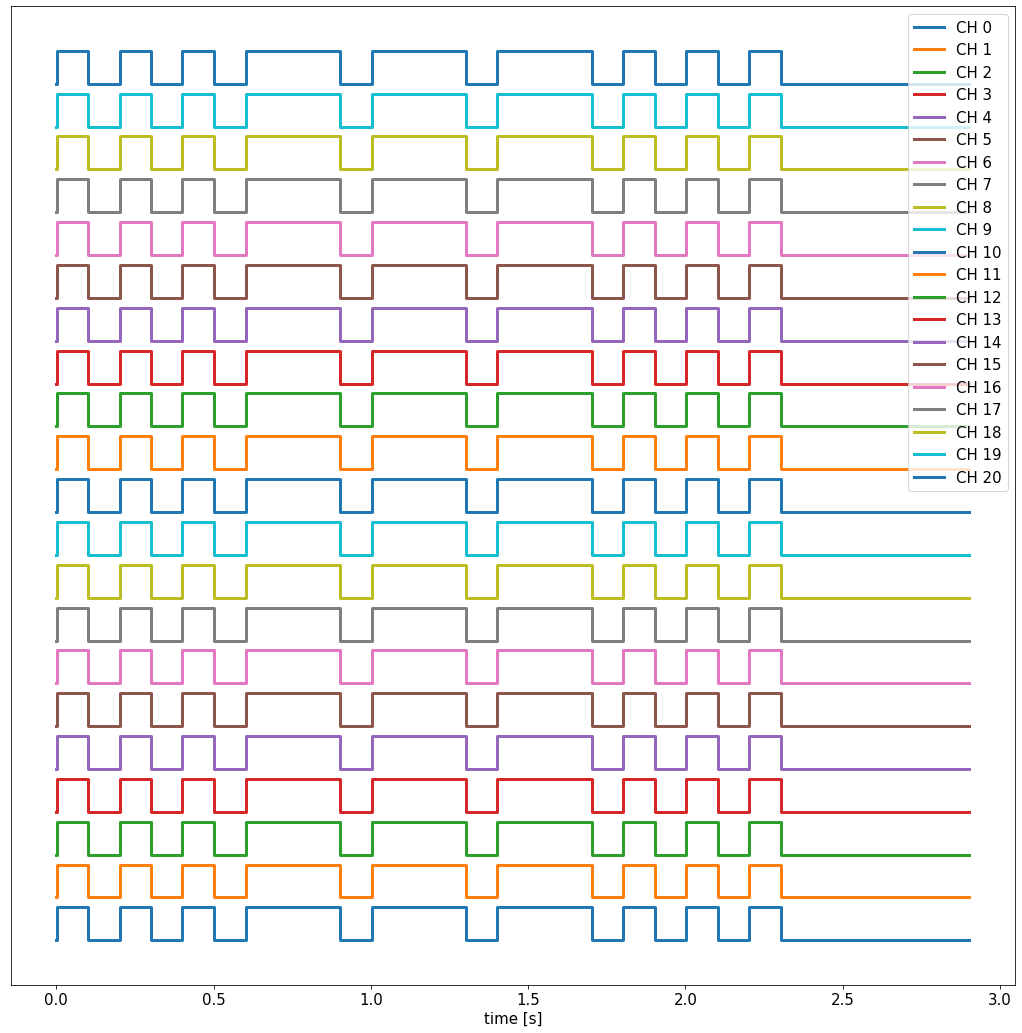

In [8]:
sequence = """// Sample program for SpinCore PulseBlaster Interpreter.
// SOS using sub routines.

start: 0x000000, 1ms, JSR, short
       0x000000, 1ms, JSR, long
       0x000000, 1ms, JSR, short
       0x000000, 500ms, BRANCH, start

// 3 Short			
short: 0xFFFFFF, 100ms
       0x000000, 100ms
       0xFFFFFF, 100ms
       0x000000, 100ms
       0xFFFFFF, 100ms
       0x000000, 100ms, RTS
			
// 3 Long
long:  0xFFFFFF, 300ms
       0x000000, 100ms
       0xFFFFFF, 300ms
       0x000000, 100ms
       0xFFFFFF, 300ms
       0x000000, 100ms, RTS
"""
pulsing = PulseSequence(sequence)
t,c = pulsing.generate_pulse_sequence()
pulsing.plot_pulse_sequence()

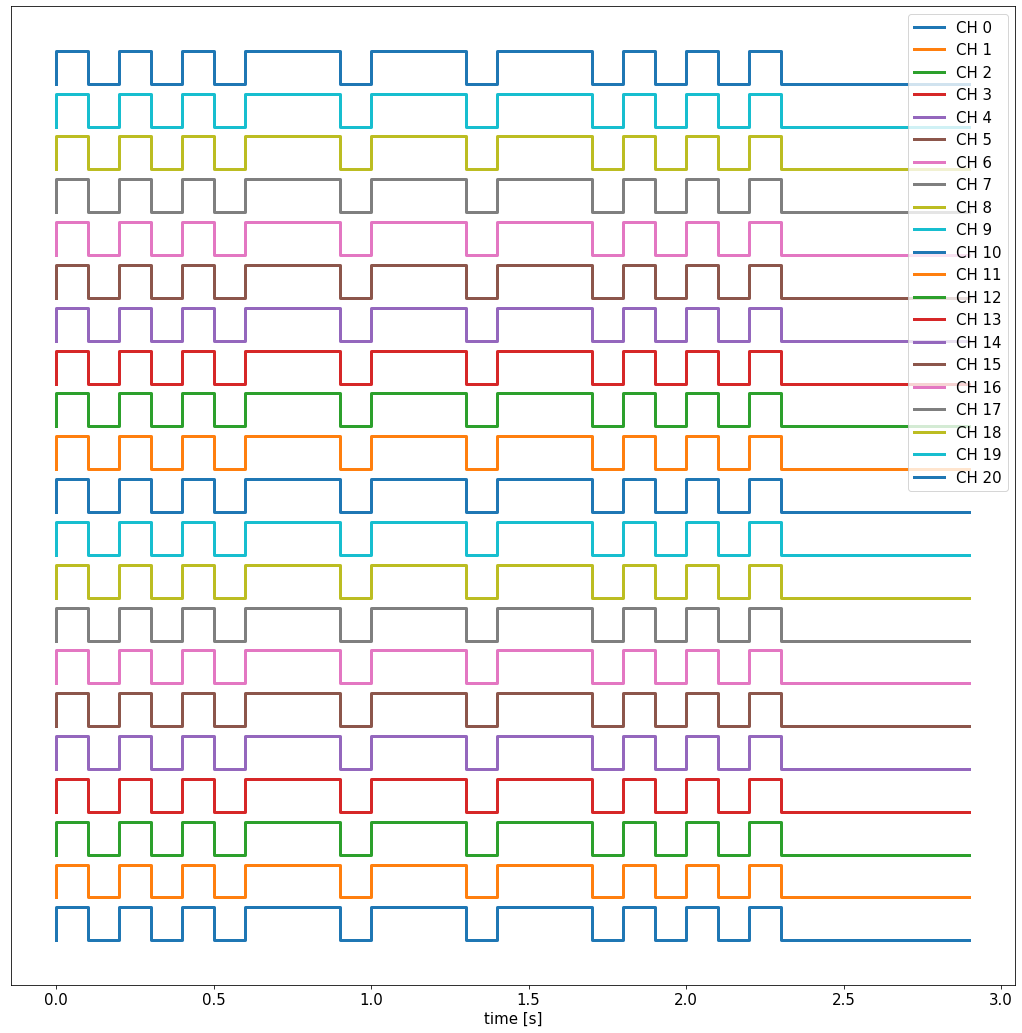

In [9]:
sequence =  """// Sample program for SpinCore PulseBlaster Interpreter.
// SOS using loops.

// 3 Short			
start: 0xFFFFFF, 100ms, LOOP, 3
       0x000000, 100ms, END_LOOP
			
// 3 Long
       0xFFFFFF, 300ms, LOOP, 3
       0x000000, 100ms, END_LOOP
			
// 3 Short			
       0xFFFFFF, 100ms, LOOP, 3
       0x000000, 100ms, END_LOOP
			
// A pause
       0x000000, 500ms, branch, start // branch to start
"""

pulsing = PulseSequence(sequence)
t,c = pulsing.generate_pulse_sequence()
pulsing.plot_pulse_sequence()

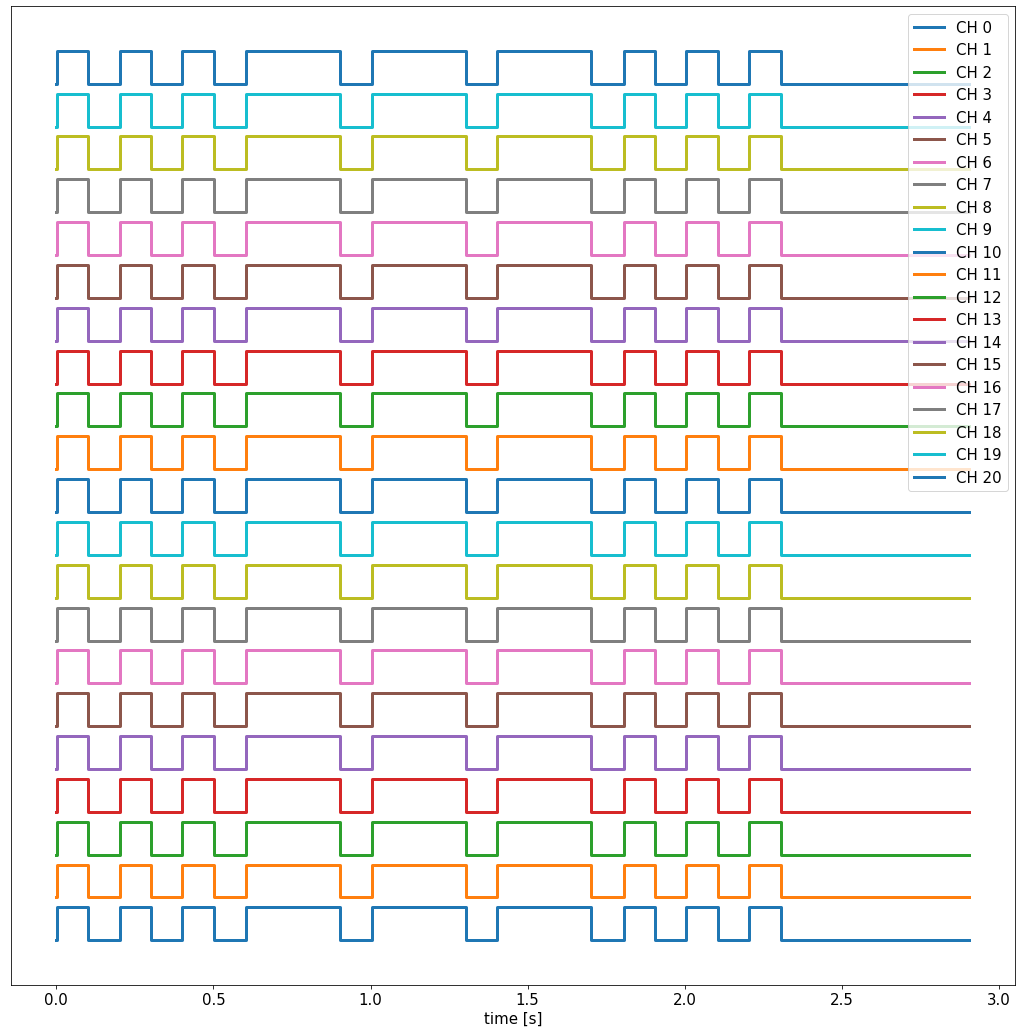

In [10]:
sequence = """// Sample program for SpinCore PulseBlaster Interpreter.
// SOS using sub routines.

start: 0x000000, 1ms, JSR, short
       0x000000, 1ms, JSR, long
       0x000000, 1ms, JSR, short
       0x000000, 500ms, BRANCH, start

// 3 Short			
short: 0xFFFFFF, 100ms, LOOP, 3
       0x000000, 100ms, END_LOOP
       0x000000, 1ms, RTS
			
// 3 Long
long:  0xFFFFFF, 300ms, LOOP, 3
       0x000000, 100ms, END_LOOP
       0x000000, 1ms, RTS
"""

pulsing = PulseSequence(sequence)
t,c = pulsing.generate_pulse_sequence()
pulsing.plot_pulse_sequence()

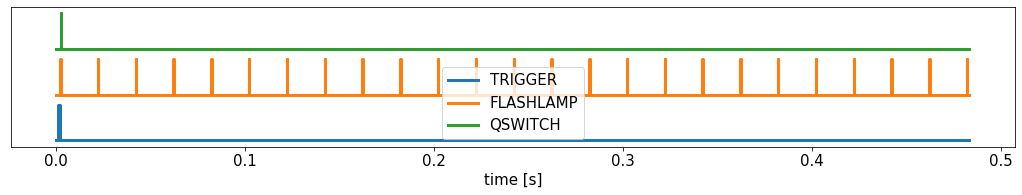

In [11]:
sequence =  """label: 0b0000 0000 0000 0000 0000 0000, 50ns  //Start with all bits off
trigger: 0b0000 0000 0000 0000 0000 0000, 1ms, wait
         0b1110 0000 0000 0000 0000 0001, 1ms
     0b1110 0000 0000 0000 0001 0000, 220us
     0b1110 0000 0000 0001 0000 0000, 100us
     0b0000 0000 0000 0000 0000 0000, 18.680ms
	 0b0000 0000 0000 0000 0000 0000, 1ms
	 0b1110 0000 0000 0000 0001 0000, 220us
	 0b1110 0000 0000 0000 0000 0000, 19.780ms
	 0b1110 0000 0000 0000 0001 0000, 220us
	 0b1110 0000 0000 0000 0000 0000, 19.780ms
	 0b1110 0000 0000 0000 0001 0000, 220us
	 0b1110 0000 0000 0000 0000 0000, 19.780ms
	 0b1110 0000 0000 0000 0001 0000, 220us
	 0b1110 0000 0000 0000 0000 0000, 19.780ms
	 0b1110 0000 0000 0000 0001 0000, 220us
	 0b1110 0000 0000 0000 0000 0000, 19.780ms
	 0b1110 0000 0000 0000 0001 0000, 220us
	 0b1110 0000 0000 0000 0000 0000, 19.780ms
	 0b1110 0000 0000 0000 0001 0000, 220us
	 0b1110 0000 0000 0000 0000 0000, 19.780ms
	 0b1110 0000 0000 0000 0001 0000, 220us
	 0b1110 0000 0000 0000 0000 0000, 19.780ms
	 0b1110 0000 0000 0000 0001 0000, 220us
	 0b1110 0000 0000 0000 0000 0000, 19.780ms
	 0b1110 0000 0000 0000 0001 0000, 220us
	 0b1110 0000 0000 0000 0000 0000, 19.780ms
	 0b1110 0000 0000 0000 0001 0000, 220us
	 0b1110 0000 0000 0000 0000 0000, 19.780ms
	 0b1110 0000 0000 0000 0001 0000, 220us
	 0b1110 0000 0000 0000 0000 0000, 19.780ms
	 0b1110 0000 0000 0000 0001 0000, 220us
	 0b1110 0000 0000 0000 0000 0000, 19.780ms
	 0b1110 0000 0000 0000 0001 0000, 220us
	 0b1110 0000 0000 0000 0000 0000, 19.780ms
	 0b1110 0000 0000 0000 0001 0000, 220us
	 0b1110 0000 0000 0000 0000 0000, 19.780ms
	 0b1110 0000 0000 0000 0001 0000, 220us
	 0b1110 0000 0000 0000 0000 0000, 19.780ms
	 0b1110 0000 0000 0000 0001 0000, 220us
	 0b1110 0000 0000 0000 0000 0000, 19.780ms
	 0b1110 0000 0000 0000 0001 0000, 220us
	 0b1110 0000 0000 0000 0000 0000, 19.780ms
	 0b1110 0000 0000 0000 0001 0000, 220us
	 0b1110 0000 0000 0000 0000 0000, 19.780ms
	 0b1110 0000 0000 0000 0001 0000, 220us
	 0b1110 0000 0000 0000 0000 0000, 19.780ms
	 0b1110 0000 0000 0000 0001 0000, 220us
	 0b1110 0000 0000 0000 0000 0000, 19.780ms
	 0b1110 0000 0000 0000 0001 0000, 220us
	 0b1110 0000 0000 0000 0000 0000, 19.780ms
	 0b1110 0000 0000 0000 0001 0000, 220us
	 0b1110 0000 0000 0000 0000 0000, 19.780ms
	 0b1110 0000 0000 0000 0001 0000, 220us
	 0b1110 0000 0000 0000 0000 0000, 1ms
         0b1110 0000 0000 0000 0000 0000, 100us, branch, trigger
"""
pulsing = PulseSequence(sequence)
t,c = pulsing.generate_pulse_sequence()
pulsing.plot_pulse_sequence(channels = ['TRIGGER', 'FLASHLAMP', 'QSWITCH'])

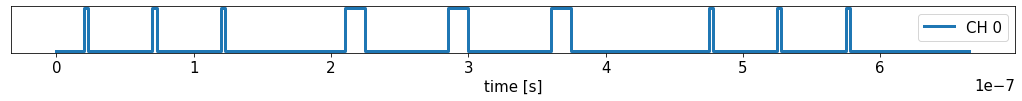

In [12]:
sequence = """// Sample program for SpinCore PulseBlaster Interpreter.
// SOS using sub routines.

start: 0x000000, 20ns, JSR, short
       0x000000, 20ns, JSR, long
       0x000000, 20ns, JSR, short
       0x000000, 20ns, BRANCH, start

// 3 Short			
short: 0b100000000000000000000001, 25ns, LOOP, 3
       0x000000, 25ns, END_LOOP
       0x000000, 20ns, RTS
			
// 3 Long
long: 0b101000000000000000000001, 50ns, LOOP, 3
       0x000000, 25ns, END_LOOP
       0x000000, 20ns, RTS
"""
pulsing_JSR_LOOP = PulseSequence(sequence)
t,c = pulsing_JSR_LOOP.generate_pulse_sequence()
pulsing_JSR_LOOP.plot_pulse_sequence()

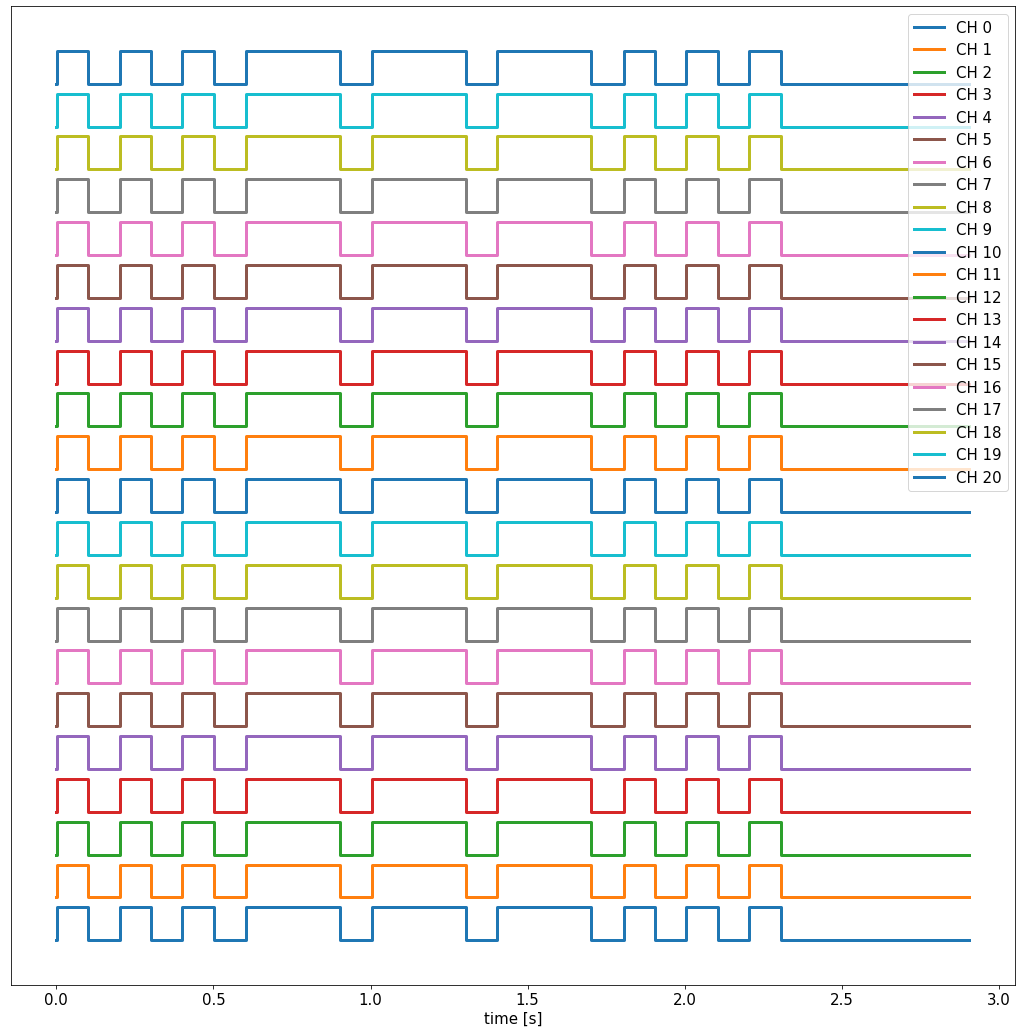

In [13]:
sequence = """// Sample program for SpinCore PulseBlaster Interpreter.
// SOS using sub routines.

start: 0x000000, 1ms, JSR, short
       0x000000, 1ms, JSR, long
       0x000000, 1ms, JSR, short
       0x000000, 500ms, BRANCH, start

// 3 Short			
short: 0xFFFFFF, 100ms, LOOP, 3
       0x000000, 100ms, END_LOOP
       0x000000, 1ms, RTS
			
// 3 Long
long:  0xFFFFFF, 300ms, LOOP, 3
       0x000000, 100ms, END_LOOP
       0x000000, 1ms, RTS
"""

pulsing = PulseSequence(sequence)
t,c = pulsing.generate_pulse_sequence()
pulsing.plot_pulse_sequence()